In [66]:
import pandas as pd
import numpy as np
import json
# データ可視化ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
import re
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import sklearn
print('sklearn version:', sklearn.__version__)
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import Pool

import warnings
warnings.filterwarnings('ignore')


lightgbm version: 2.3.0
sklearn version: 0.22.1


In [67]:
train = pd.read_csv('../data/raw/train2.csv')
test = pd.read_csv('../data/raw/test2.csv')

In [68]:
drop_columns = ['OpenFloor', 'Workshop', 'D', 'S', 'Studio', 'Maisonette', 'K', 'R']
train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)

In [69]:
y = train['y']
train = train.drop('y', axis=1)

In [70]:
data = pd.concat((train, test))

In [71]:
data_city_mean['Area'].iloc[1]

65.15835616438356

In [72]:
city_mean_colums = ['MunicipalityCode', 'Area', 'LandShape', 'Frontage', 'BuildingYear',
                           'TotalFloorArea', 'h31_price', 'Breadth', 'Structure', 'FloorAreaRatio']

data_city_mean =  data[city_mean_colums].groupby('MunicipalityCode').mean()

for i in city_mean_colums:
    if i != 'MunicipalityCode':
        data['citycode_mean_' + i] = data['MunicipalityCode']
        for j, value in enumerate(data['MunicipalityCode'].unique()):
            data['citycode_mean_' + i] = data['citycode_mean_' + i].replace(value, data_city_mean[i].iloc[j])

In [73]:
data_city_max =  data[city_mean_colums].groupby('MunicipalityCode').max()

for i in city_mean_colums:
    if i != 'MunicipalityCode':
        data['citycode_max_' + i] = data['MunicipalityCode']
        for j, value in enumerate(data['MunicipalityCode'].unique()):
            data['citycode_max_' + i] = data['citycode_max_' + i].replace(value, data_city_mean[i].iloc[j])

In [74]:
period_mean_colums = ['Period', 'Area', 'LandShape', 'Frontage', 'BuildingYear',
                           'TotalFloorArea', 'h31_price', 'Breadth', 'Structure', 'FloorAreaRatio', 'longitude']

data_period_mean =  data[period_mean_colums].groupby('Period').mean()

for i in period_mean_colums:
    if i != 'Period':
        data['period_mean_' + i] = data['Period']
        for j, value in enumerate(data['Period'].unique()):
            data['period_mean_' + i] = data['period_mean_' + i].replace(value, data_period_mean[i].iloc[j])
            
data_period_max =  data[period_mean_colums].groupby('Period').max()

for i in period_mean_colums:
    if i != 'Period':
        data['period_max_' + i] = data['Period']
        for j, value in enumerate(data['Period'].unique()):
            data['period_max_' + i] = data['period_max_' + i].replace(value, data_period_max[i].iloc[j])            

In [75]:
data['TimeToNearestStation×NearestStation'] = data['NearestStation'] * data['TimeToNearestStation']
data['h31_27_mean_office'] = data['office'] * data['h31_27_mean']
data['h31_27_mean_ostore'] = data['store'] * data['h31_27_mean']
data['office_and_store'] = data['office'] * data['store']

In [76]:
train = data[:len(train)]

In [77]:
test = data[len(train):]

In [79]:
# y_pred = np.zeros(test.shape[0], dtype='float32')
# train_pred = np.zeros(X.shape[0], dtype='float32')

X_train, X_valid, y_train, y_valid = train_test_split(train, y, random_state=0)
# CatBoost が扱うデータセットの形式に直す
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_valid, label=y_valid)

params = {
        'loss_function': 'RMSE',
        'iterations': 50000,
        'od_type': "Iter",
        'depth': 10,
        'colsample_bylevel': 0.5,
        'early_stopping_rounds': 300,
        'l2_leaf_reg': 18,
        'random_seed': 42,
        'use_best_model': True
}


model =  CatBoostRegressor(**params)
model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=200,              
)
    

y_val_pred = model.predict(X_valid)
val_score = np.sqrt(mean_squared_error(y_valid, y_val_pred))
print('RMSE:', val_score)




0:	learn: 322.8108257	test: 243.4779286	best: 243.4779286 (0)	total: 145ms	remaining: 2h 24s
200:	learn: 175.2613373	test: 166.0705982	best: 166.0705982 (200)	total: 12.4s	remaining: 51m 5s
400:	learn: 136.7936445	test: 157.4358214	best: 157.4358214 (400)	total: 25.7s	remaining: 52m 59s
600:	learn: 116.3919078	test: 153.8784291	best: 153.8784291 (600)	total: 38.6s	remaining: 52m 49s
800:	learn: 101.8802338	test: 151.8315726	best: 151.8315726 (800)	total: 51.5s	remaining: 52m 41s
1000:	learn: 89.4534379	test: 150.4388366	best: 150.4282407 (998)	total: 1m 4s	remaining: 52m 38s
1200:	learn: 79.2166915	test: 149.0222320	best: 149.0146971 (1194)	total: 1m 17s	remaining: 52m 35s
1400:	learn: 72.0249935	test: 148.1171345	best: 148.1124696 (1399)	total: 1m 31s	remaining: 52m 38s
1600:	learn: 66.9335141	test: 147.7920989	best: 147.7859038 (1596)	total: 1m 44s	remaining: 52m 43s
1800:	learn: 62.1202446	test: 147.3282418	best: 147.3161191 (1796)	total: 1m 57s	remaining: 52m 30s
2000:	learn: 57.56

In [81]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns
feature_importances['importance'] = model.get_feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

,feature,importance
5,Area,23.217583
8,TotalFloorArea,9.793788
25,h31_price,7.355360
7,Frontage,5.602155
15,Breadth,4.368403
...,...,...
29,building_id,0.003223
30,L,0.002254
69,period_max_Frontage,0.000000
68,period_max_LandShape,0.000000


In [83]:
feature_importances[40:]

,feature,importance
6,LandShape,0.386078
64,period_mean_Structure,0.380133
11,Use,0.373018
55,citycode_max_Structure,0.372236
45,citycode_mean_Breadth,0.366738
14,Classification,0.360184
41,citycode_mean_Frontage,0.327420
54,citycode_max_Breadth,0.265825
0,Type,0.259999
32,office,0.258640


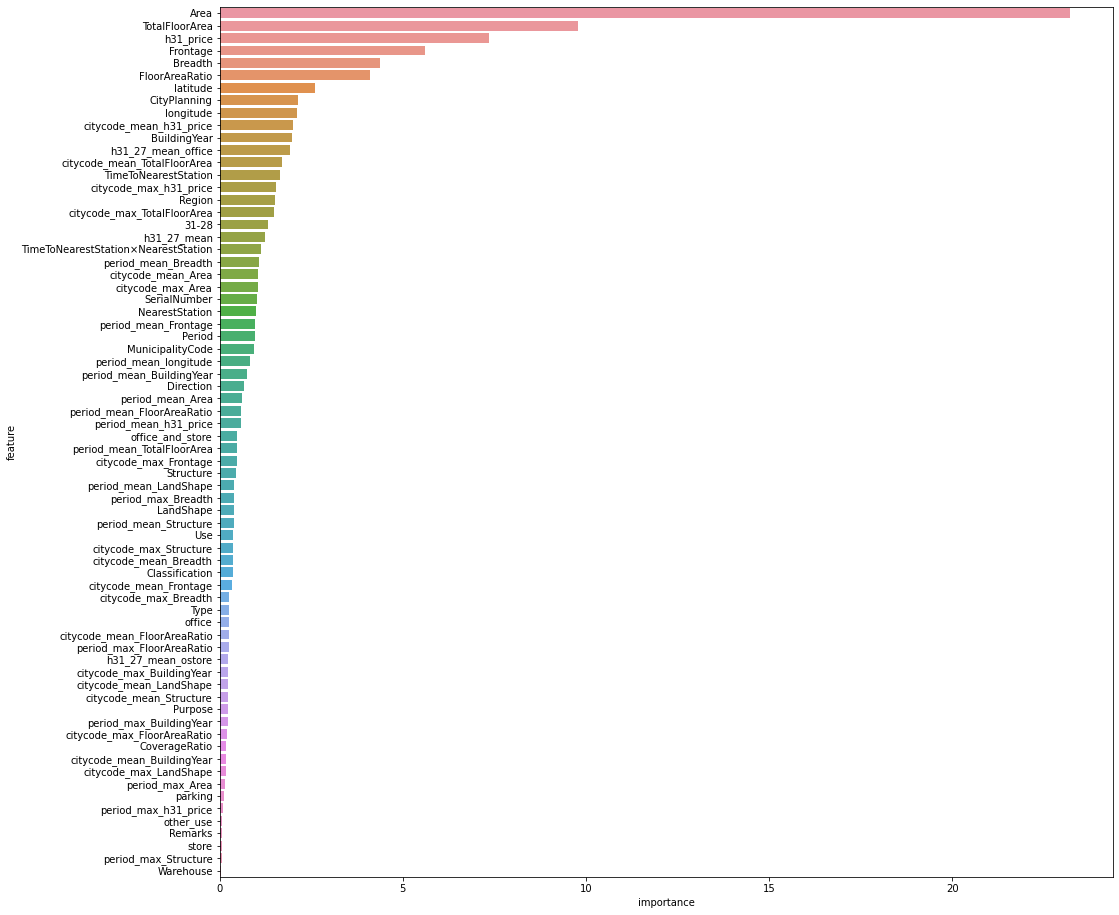

In [84]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(70), x='importance', y='feature')

In [86]:
y_pred  = model.predict(test)
y_pred = np.round(y_pred, 2)

In [87]:
submit = pd.read_csv('../data/raw/test_data.csv')

In [88]:
sub = pd.DataFrame({'id': submit['id'], 'y': y_pred})

In [89]:
sub.query('y < 0')

,id,y
1,2,-0.67
24,25,-2.91
57,58,-7.46
90,91,-4.82
141,142,-3.49
...,...,...
34797,34798,-5.37
34798,34799,-18.28
34813,34814,-2.17
34824,34825,-15.11


In [90]:
for i in sub[sub['y'] < 0]['id']:
    sub['y'][i-1] = 0 

In [91]:
sub.to_csv('sub_cat_3.csv', index=False)